In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#多输入多输出
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Multiply, Lambda
from keras.layers import LSTM, GRU, Embedding, Flatten, Reshape, Layer, Lambda ,Average, merge, Conv2D, MaxPool2D, GlobalAveragePooling2D, Conv1D, MaxPooling1D, concatenate, Input, Bidirectional, RepeatVector, Concatenate, Dot, Permute, TimeDistributed, SpatialDropout1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

Using TensorFlow backend.


In [4]:
#调用self attention
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.49.0-cp37-none-any.whl size=19468 sha256=b352cca2f2f34e6ed19c2c8c8b94cba094ec6900fcdfb738f5124daff29745b3
  Stored in directory: /root/.cache/pip/wheels/6f/9d/c5/26693a5092d9313daeae94db04818fc0a2b7a48ea381989f34
Successfully built keras-self-attention


In [5]:
#导入文件
#csv版本
'''input_file="/content/drive/My Drive/Benchmark_PageGap/PageGap_445.csv"   #PageGap240000
dataset=read_csv(input_file, header=None, index_col=None, delimiter=',')
dataset=dataset[2].values[40000:]
#dataset.drop(, axis=1, inplace=True)
dataset'''

#out版本
input_file="/content/drive/My Drive/Benchmark_PageGap/PageGap_RW/PageGap_526_RW.out" #521  
dataset=read_csv(input_file, header=None, index_col=None, sep=' ')
start=2800000
end=3000000
datasetRW=dataset[0].values[start:end]
#dataset.drop(, axis=1, inplace=True)
datasetD=dataset[1].values[start:end]
dataset


,0,1
0,0,43
1,0,-43
2,0,43
3,0,-43
4,0,40
...,...,...
8136228,0,-7552
8136229,0,0
8136230,1,7552
8136231,0,-7552


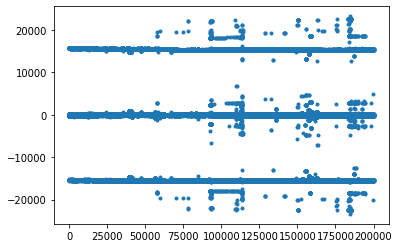

In [6]:
#查看数据分布
plt.plot(datasetD, '.')
plt.show()

In [7]:
#读写数据
datasetRW

array([0, 0, 0, ..., 1, 0, 0])

In [8]:
#delta数据
datasetD

array([     0,  15703, -15703, ...,   -241, -15296,  15537])

In [9]:
#提前先分好训练集和测试集
train_size = int(len(datasetD) * 0.8)
train_Delta = datasetD[:train_size]
test_Delta = datasetD[train_size:]
train_RW = datasetRW[:train_size]
test_RW = datasetRW[train_size:]
print(train_Delta)
print(test_Delta)

[     0  15703 -15703 ...  15554   -256 -15298]
[ 15554   -256    256 ...   -241 -15296  15537]


In [10]:
#将训练集的delta转成list和set
list_a=train_Delta.tolist()
print("Train_List长度：",len(list_a))

list_b=test_Delta.tolist()
print("Test_List长度：",len(list_b))

#查看delta的种类
set_a=set(list_a)
type_n_a=len(set_a)
print("Train_Set种类：",type_n_a)

set_b=set(list_b)
type_n_b=len(set_b)
print("Test_Set种类：",type_n_b)

Train_List长度： 160000
Test_List长度： 40000
Train_Set种类： 1304
Test_Set种类： 566


In [11]:
value_cnt_a = {}
for delta in list_a:
	# get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
	value_cnt_a[delta] = value_cnt_a.get(delta, 0) + 1

# 打印输出结果
print("Train字典收集训练集（delta类别-次数）：",value_cnt_a)
print("Train各delta值：",[key for key in value_cnt_a.keys()])
Vals_a=[delta for delta in value_cnt_a.values()]
print("Train各delta值的次数：",Vals_a)
print("Train_delta种类：",len(Vals_a))

value_cnt_b = {}
for delta in list_b:
	# get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
	value_cnt_b[delta] = value_cnt_b.get(delta, 0) + 1

# 打印输出结果
print("Test字典收集训练集（delta类别-次数）：",value_cnt_b)
print("Test各delta值：",[key for key in value_cnt_b.keys()])
Vals_b=[delta for delta in value_cnt_b.values()]
print("Test各delta值的次数：",Vals_b)
print("Test_delta种类：",len(Vals_b))

Train字典收集训练集（delta类别-次数）： {0: 33074, 15703: 32, -15703: 1, -256: 16200, -15447: 28, 256: 9467, -15446: 161, 15702: 163, 255: 354, -199: 1, -15247: 1, 1: 519, -15445: 162, 15701: 163, -201: 1, -15245: 1, 15488: 198, -15488: 82, -203: 1, -15242: 1, 213: 263, 15700: 146, -15444: 147, -15701: 1, -206: 1, -15239: 1, 212: 162, -207: 1, -15237: 1, -15443: 166, 15699: 149, -15700: 3, -210: 2, -15233: 1, 15698: 162, -15442: 135, 210: 193, 211: 196, -212: 6, -15486: 7, -15441: 133, 15697: 148, -15698: 24, -470: 1, -15484: 4, -15697: 16, 209: 135, -216: 1, -15481: 3, -15440: 154, 15696: 171, -219: 1, -15477: 4, -15439: 161, 15695: 160, -15696: 19, -220: 1, -15475: 4, 208: 185, 207: 173, -223: 40, -15472: 3, 15694: 132, -15438: 148, 206: 193, -15695: 1, -225: 61, -15469: 9, 15693: 156, -15437: 166, -15693: 2, -1: 318, -227: 159, -15466: 7, 205: 200, 15692: 155, -15436: 162, -230: 68, -15463: 1, -232: 1, -15460: 1, 203: 166, -15435: 153, 204: 194, 15691: 150, -234: 1, -15458: 2, 257: 338, -15692: 1

In [12]:
from random import randint
#统计delta计数较少的index，考虑归为新类
#字典收集训练集的delta值
value_cnt = {}
for delta in list_a:
	# get(value, num)函数的作用是获取字典中value对应的键值, num=0指示初始值大小。
	value_cnt[delta] = value_cnt.get(delta, 0) + 1

# 打印输出结果
print("字典收集训练集（delta类别-次数）：",value_cnt)
print("各delta值：",[key for key in value_cnt.keys()])
Vals=[delta for delta in value_cnt.values()]
print("各delta值的次数：",Vals)
print("delta种类：",len(Vals))

Vals_Record=[delta for delta in value_cnt.keys() if value_cnt[delta] >5] #要保留记录的delta
Vals_Thr_Num=[delta for delta in Vals if delta >5] #要保留记录的delta次数
Vals_Thr_Dele=[delta for delta in value_cnt.keys() if value_cnt[delta] <=5] #次数小于等于10次的delta，归成一类
Vals_Thr_Dele_Num=[delta for delta in Vals if delta <=5] #要归为一类记录的delta次数
print("要保留的delta：",Vals_Record)
print("要保留的delta次数：",Vals_Thr_Num)
print("要保留的delta种类数：",len(Vals_Thr_Num))
#将不保留记录的delta都归为一个新类
type_new=len(Vals_Thr_Num)+1

print("要删除的delta：",Vals_Thr_Dele)
print("要删除的delta次数：",Vals_Thr_Num)
print("要删除的delta种类：",len(Vals_Thr_Dele))

#设置一个新类，统归为初始值0，利用随机生成一个0-type_new之间的数，作为最终新类值
init_val=0
while init_val in Vals_Record:
  init_val=randint(0,type_new)
print("新类的值: ",init_val)

#对于训练集，不保留的类都归为值：init_val
print(len(set(train_Delta)))
print('不保留的类都归为值：',init_val)
for i in Vals_Thr_Dele:
  train_Delta[train_Delta==i]=init_val

#对于测试集，同样将不保留的值归为：init_val
for i in range(len(test_Delta)):
  if test_Delta[i] not in Vals_Record:
    test_Delta[i]=init_val

print(set(test_Delta))

print(len(set(train_Delta)))
  



字典收集训练集（delta类别-次数）： {0: 33074, 15703: 32, -15703: 1, -256: 16200, -15447: 28, 256: 9467, -15446: 161, 15702: 163, 255: 354, -199: 1, -15247: 1, 1: 519, -15445: 162, 15701: 163, -201: 1, -15245: 1, 15488: 198, -15488: 82, -203: 1, -15242: 1, 213: 263, 15700: 146, -15444: 147, -15701: 1, -206: 1, -15239: 1, 212: 162, -207: 1, -15237: 1, -15443: 166, 15699: 149, -15700: 3, -210: 2, -15233: 1, 15698: 162, -15442: 135, 210: 193, 211: 196, -212: 6, -15486: 7, -15441: 133, 15697: 148, -15698: 24, -470: 1, -15484: 4, -15697: 16, 209: 135, -216: 1, -15481: 3, -15440: 154, 15696: 171, -219: 1, -15477: 4, -15439: 161, 15695: 160, -15696: 19, -220: 1, -15475: 4, 208: 185, 207: 173, -223: 40, -15472: 3, 15694: 132, -15438: 148, 206: 193, -15695: 1, -225: 61, -15469: 9, 15693: 156, -15437: 166, -15693: 2, -1: 318, -227: 159, -15466: 7, 205: 200, 15692: 155, -15436: 162, -230: 68, -15463: 1, -232: 1, -15460: 1, 203: 166, -15435: 153, 204: 194, 15691: 150, -234: 1, -15458: 2, 257: 338, -15692: 1, -15

In [13]:
trainl=test_Delta.tolist()
setl=set(trainl)
typel=len(setl)
print("Train_Set种类：",typel)

Train_Set种类： 104


In [14]:
#编码转换
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



#查看train_Delta和test_Delta种类：
listD_train=train_Delta.tolist()
listD_test=test_Delta.tolist()
set_d_train=set(listD_train)
set_d_test=set(listD_test)
print("查看train_Delta种类：",len(set_d_train))
print("查看test_Delta种类：",len(set_d_test))



查看train_Delta种类： 479
查看test_Delta种类： 104


In [15]:
#编码的时候先合并train和test的数据，相当于用同样的方法transform
whole_delta=np.concatenate((train_Delta,test_Delta))
#integer encoding方法（LabelEncoder）
values=whole_delta
label_encoder=LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print("训练集推出的Integer_encoder：",integer_encoded)

#找种类的最大值
max_integer_encoded=max(integer_encoded)+1
print("最大的integer_encoded_num：",max_integer_encoded)
max_integer=type_new-1
num_bit=int(math.log(max_integer, 2)+1)
print("需要转的二进制：",max_integer)
print("应该用多少bit表示：",num_bit)

# define convert_to_binary method
# 每个值转特定位数的binary编码
def convert_to_binary(origin, num_bit=1):
  binary_encoded = []
  num_bit_str=str(num_bit)
  for element in origin:
    binary_encoded.append(list(map(int,list(('{:0'+num_bit_str+'b}').format(element)))))
  return np.array(binary_encoded)

binary_encoded = convert_to_binary(integer_encoded, num_bit)
print("Binary_encoded：",binary_encoded)

# define convert_to_onehot method
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("Onehot_encoded：",onehot_encoded)

训练集推出的Integer_encoder： [268 472 274 ... 274 226 274]
最大的integer_encoded_num： 479
需要转的二进制： 478
应该用多少bit表示： 9
Binary_encoded： [[1 0 0 ... 1 0 0]
 [1 1 1 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 0]
 [0 1 1 ... 0 1 0]
 [1 0 0 ... 0 1 0]]
Onehot_encoded： [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:

print(type(integer_encoded))
print("整数编码shape：",integer_encoded.shape)
print(type(onehot_encoded))
print("独热编码shape：",onehot_encoded.shape)
print(type(binary_encoded))
print("二进制编码：",binary_encoded.shape)



<class 'numpy.ndarray'>
整数编码shape： (200000, 1)
<class 'numpy.ndarray'>
独热编码shape： (200000, 479)
<class 'numpy.ndarray'>
二进制编码： (200000, 9)


In [17]:
#读写数据
RW = datasetRW[:]
RW = np.reshape(RW, (RW.shape[0],1))
RW.shape

(200000, 1)

In [18]:
#创建数据集的输入和输出
def create_dataset(datasetX, datasetY, look_back=1, pridict_size=1):
	dataX, dataY = [], []
	for i in range(len(datasetX)-look_back-pridict_size):
		a = datasetX[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(datasetY[i + look_back:(i+look_back+pridict_size), :])
	return np.array(dataX), np.array(dataY)

In [19]:
#确定lookback的size
look_back = 50
pridict_size = 1
type_new

#按lookback的size创建训练集输入和输出,trainX的维度((train_size-look_back-pridict_size),look_back)
#训练集的数据
integer_encoded_train=integer_encoded[:train_size]
binary_encoded_train=binary_encoded[:train_size]
integer_encoded_test=integer_encoded[train_size:]
binary_encoded_test=binary_encoded[train_size:]

#训练集的读写数据
RW_train=RW[:train_size]
RW_test=RW[train_size:]

#valuesX, valuesY = create_dataset(integer_encoded, onehot_encoded, look_back, pridict_size)    #onehot_encoded
trainX, trainY = create_dataset(integer_encoded_train, binary_encoded_train, look_back, pridict_size)    #binary_encoded
testX, testY = create_dataset(integer_encoded_test, binary_encoded_test, look_back, pridict_size)

trainX_RW, trainY_RW = create_dataset(RW_train, RW_train, look_back, pridict_size) 
testX_RW, testY_RW = create_dataset(RW_test, RW_test, look_back, pridict_size)


print('TrainX Shape: ',trainX.shape)
print('TrainY Shape: ',trainY.shape)
print('TestX Shape: ',testX.shape)
print('TestY Shape: ',testY.shape)

print('TrainX_RW Shape: ',trainX_RW.shape)
print('TrainY_RW Shape: ',trainY_RW.shape)
print('TestX_RW Shape: ',testX_RW.shape)
print('TestY_RW Shape: ',testY_RW.shape)

TrainX Shape:  (159949, 50, 1)
TrainY Shape:  (159949, 1, 9)
TestX Shape:  (39949, 50, 1)
TestY Shape:  (39949, 1, 9)
TrainX_RW Shape:  (159949, 50, 1)
TrainY_RW Shape:  (159949, 1, 1)
TestX_RW Shape:  (39949, 50, 1)
TestY_RW Shape:  (39949, 1, 1)


In [20]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[2]*trainX.shape[1]))
print("feature:",trainX.shape)
testX = np.reshape(testX, (testX.shape[0], testX.shape[2]*testX.shape[1]))
print('TrainX Shape: ',trainX.shape)
print('TrainY Shape: ',trainY.shape)

print('trainX type: ',type(trainX))

trainX_RW=np.reshape(trainX_RW, (trainX_RW.shape[0], trainX_RW.shape[2]*trainX_RW.shape[1]))
testX_RW = np.reshape(testX_RW, (testX_RW.shape[0], testX_RW.shape[2]*testX_RW.shape[1]))
print('trainX_RW Shape: ',trainX_RW.shape)
print('trainY_RW Shape: ',trainY_RW.shape)

feature: (159949, 50)
TrainX Shape:  (159949, 50)
TrainY Shape:  (159949, 1, 9)
trainX type:  <class 'numpy.ndarray'>
trainX_RW Shape:  (159949, 50)
trainY_RW Shape:  (159949, 1, 1)


In [21]:
#自定义层
class Layer1(Layer):
  def __init__(self, unit, activation=None, **kwargs):
    self.unit=unit
    self.activation=Activation(activation)
    super(Layer1, self).__init__(**kwargs)

  def build(self, input_shape):
    self.kernel=self.add_weight(name='kernel',
                  shape=(input_shape[1], self.unit),
                  initializer='uniform',
                  trainable=True)
    self.bias=self.add_weight(name='bias',
                  shape=(self.unit, ),
                  initializer='zeros',
                  trainable=True)
    super(Layer1, self).build(input_shape)

  def call(self,x):
    return self.activation(x @ self.kernel+self.bias)

In [23]:
from keras import backend as K
from keras_self_attention import SeqSelfAttention


In [27]:

input_RW=Input(shape=(look_back,))
em_R=Embedding(2, 32, input_length=look_back)(input_RW)
em_R=Dropout(0.2)(em_R)

X=Input(shape=(look_back,), name="Input_D")

em=Embedding(type_new, 32, input_length=look_back)(X)

  #将RW和Delta合为一体
merges = Average()([em, em_R])

a1 = Bidirectional(LSTM(128, return_sequences=True), merge_mode='concat', name='Bid_LSTM')(merges)
a2 = LSTM(128, return_sequences=True)(a1)
a2 = SeqSelfAttention(attention_activation='sigmoid')(a2)
a2 = Flatten()(a2)

# Output of convolutional layers
conv_out = RepeatVector(2)(a2)

# Split to two parts
split = Lambda(lambda x: tf.split(x, 2, axis=1))(conv_out)
# 
Delta_part = Flatten()(split[0])
RW_part = Flatten()(split[1])

# Concatenate with categorical features
#x = concatenate([conv_out] + cat_flatten)
x = Dense(pridict_size*num_bit, activation="relu")(Delta_part)
x = Reshape((pridict_size,num_bit))(x)
outputs = Activation('sigmoid')(x)

rw = Dense(pridict_size*num_bit, activation="relu")(RW_part)
rw = Dense(pridict_size, activation="relu")(rw)
rw = Reshape((pridict_size, 1))(rw)
outputs_rw = Activation('sigmoid')(rw)

model = Model(inputs=[X, input_RW], outputs=[outputs, outputs_rw])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])#tf.compat.v1.keras.metrics.binary_accuracy
early_stopping=EarlyStopping(monitor='val_loss',patience=15,verbose=2)
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
Input_D (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 32)       64          input_4[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 50, 32)       15328       Input_D[0][0]                   

In [28]:
history=model.fit([trainX,trainX_RW],[trainY, trainY_RW], epochs=20, batch_size=256, 
                  verbose=1
                  , validation_data=([testX,testX_RW], [testY,testY_RW]),
                  callbacks=[early_stopping])

'''
history=model.fit([trainX,trainRW_X],trainY, epochs=5, batch_size=32, 
                  verbose=1, validation_data=([testX,testRW_X], testY),
                  callbacks=[early_stopping])
'''
'''
history=model.fit(trainRW_X, trainRW_Y, 
                  epochs=20, batch_size=32, 
                  verbose=1, validation_data=(testRW_X, testRW_Y),
                  callbacks=[early_stopping])'''


Train on 159949 samples, validate on 39949 samples
Epoch 1/20
159949/159949 [==============================] - 72s 451us/step - loss: 1.3038 - activation_1_loss: 0.6107 - activation_2_loss: 0.6931 - activation_1_acc: 0.6950 - activation_2_acc: 0.6858 - val_loss: 1.3002 - val_activation_1_loss: 0.6073 - val_activation_2_loss: 0.6931 - val_activation_1_acc: 0.7576 - val_activation_2_acc: 0.6597
Epoch 2/20
159949/159949 [==============================] - 70s 438us/step - loss: 1.2109 - activation_1_loss: 0.5177 - activation_2_loss: 0.6931 - activation_1_acc: 0.7923 - activation_2_acc: 0.6860 - val_loss: 1.2845 - val_activation_1_loss: 0.5919 - val_activation_2_loss: 0.6931 - val_activation_1_acc: 0.7817 - val_activation_2_acc: 0.6597
Epoch 3/20
159949/159949 [==============================] - 70s 438us/step - loss: 1.0860 - activation_1_loss: 0.5017 - activation_2_loss: 0.5843 - activation_1_acc: 0.8107 - activation_2_acc: 0.8665 - val_loss: 1.2007 - val_activation_1_loss: 0.5959 - val_a

'\nhistory=model.fit(trainRW_X, trainRW_Y, \n                  epochs=20, batch_size=32, \n                  verbose=1, validation_data=(testRW_X, testRW_Y),\n                  callbacks=[early_stopping])'

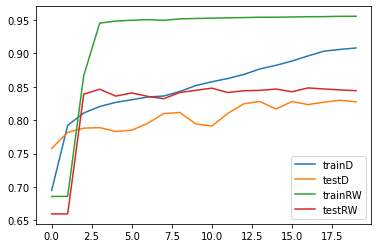

In [29]:
#lstm+sa
plt.plot(history.history['activation_1_acc'], label='trainD')
plt.plot(history.history['val_activation_1_acc'], label='testD')
plt.plot(history.history['activation_2_acc'], label='trainRW')
plt.plot(history.history['val_activation_2_acc'], label='testRW')
#plt.plot(history.history['acc'], label='train_dense_0')
#plt.plot(history.history['val_acc'], label='test_dense_0')
plt.legend()
plt.show()

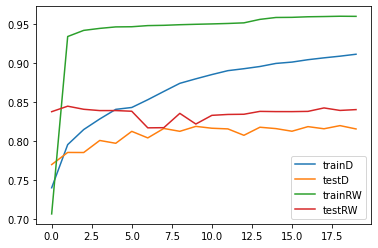

In [ ]:
plt.plot(history.history['activation_2_acc'], label='trainD')
plt.plot(history.history['val_activation_2_acc'], label='testD')
plt.plot(history.history['activation_3_acc'], label='trainRW')
plt.plot(history.history['val_activation_3_acc'], label='testRW')
#plt.plot(history.history['acc'], label='train_dense_0')
#plt.plot(history.history['val_acc'], label='test_dense_0')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(trainX[:3,:])
prediction

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


array([[2.8505789e-05, 9.9865842e-01, 9.9998295e-01, 3.1052155e-03,
        4.0482678e-03, 9.0687745e-06, 7.3090373e-03, 9.9349171e-01,
        9.9952722e-01],
       [6.6169865e-02, 1.0445007e-01, 9.0387994e-01, 9.2764282e-01,
        9.9668270e-01, 9.0167761e-01, 9.6083277e-01, 8.5861337e-01,
        9.1281617e-01],
       [4.2159379e-02, 9.5037341e-01, 9.9959904e-01, 3.0775039e-02,
        9.9855024e-01, 1.8715746e-04, 6.1138938e-03, 8.2155608e-02,
        2.1979475e-01]], dtype=float32)

In [ ]:
trainY_list[0][0:3]

array([[0, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 0]])

In [ ]:
trainY_list[1][0:3]

IndexError: ignored